In [1]:
# the files called in this notebook are in OSC

#Y1 Data

import os, sys
import esutil
import healpy as hp
import numpy as np
#%matplotlib inline

#%load_ext autoreload
#%autoreload 2

# call required functions from modules 
sys.path.append('code_py3/')
from cmass_modules import io
from utils import matchCatalogsbyPosition, hpHEALPixelToRaDec, HealPixifyCatalogs, spatialcheck
from xd import mixing_color, XD_fitting_X, assignCMASSProb, doVisualization_1d
from run_DMASS import priorCut_test

In /users/PCON0003/warner785/.conda/envs/DES_env/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /users/PCON0003/warner785/.conda/envs/DES_env/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /users/PCON0003/warner785/.conda/envs/DES_env/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.


In [2]:
pwd

'/users/PCON0003/warner785/DMASSY3/code_py3'

In [3]:
#correct catalogs:

# calling stripe82 gold catalogue -----------------------------
train_path = '/fs/scratch/PCON0003/warner785/bwarner/gold_cat/GOLD_STRIPE82/'
path =  train_path
train_keyword = 'Y1A1_GOLD_STRIPE82_v2'
    
columns = ['FLAGS_GOLD', 'FLAGS_BADREGION', 'MAG_MODEL_G', 'MAG_MODEL_R', 'MAG_MODEL_I', 'MAG_MODEL_Z',\
               'MAG_DETMODEL_G', 'MAG_DETMODEL_R', 'MAG_DETMODEL_I', 'MAG_DETMODEL_Z', 'MAGERR_DETMODEL_G',\
               'MAGERR_DETMODEL_R', 'MAGERR_DETMODEL_I', 'MAGERR_DETMODEL_Z', 'MAGERR_MODEL_G', 'MAGERR_MODEL_R',\
               'MAGERR_MODEL_I', 'MAGERR_MODEL_Z', 'MAG_AUTO_G', 'MAG_AUTO_R', 'MAG_AUTO_I', 'MAG_AUTO_Z', 'RA',\
               'DEC', 'COADD_OBJECTS_ID', 'MODEST_CLASS', 'HPIX', 'DESDM_ZP',\
               'SLR_SHIFT_G', 'SLR_SHIFT_R', 'SLR_SHIFT_I', 'SLR_SHIFT_Z', 'SLR_SHIFT_Y', 'EBV']

gold_st82 = io.SearchAndCallFits(path = train_path, columns = columns, keyword = train_keyword )
gold_st82 = gold_st82[(gold_st82['MODEST_CLASS'] == 1)&(gold_st82['FLAGS_GOLD'] == 0 )]
    
#print(gold_st82.size)

#implement Cuts.keepgoodregion:

def keepGoodRegion(des, hpInd = False, balrog=None):
    import healpy as hp
    import fitsio
    # 25 is the faintest object detected by DES
    # objects larger than 25 considered as Noise
    
    path = '/fs/scratch/PCON0003/warner785/bwarner/'
    #LSSGoldmask = fitsio.read(path+'Y1LSSmask_v2_il22_seeil4.0_nside4096ring_redlimcut.fits')
    #LSSGoldmask = fitsio.read(path+'Y1LSSmask_v1_il22seeil4.04096ring_redlimcut.fits')
    LSSGoldmask = fitsio.read(path+'Y1LSSmask_v2_redlimcut_il22_seeil4.0_4096ring.fits')
    #Y1LSSmask_v1_il22seeil4.04096ring_redlimcut.fits
    #frac_cut = LSSGoldmask['FRAC'] > 0.8
    #ind_good_ring = LSSGoldmask['PIXEL'][frac_cut]
    ind_good_ring = LSSGoldmask['PIXEL']
    
    # healpixify the catalog.
    nside=4096
    # Convert silly ra/dec to silly HP angular coordinates.
    phi = des['RA'] * np.pi / 180.0
    theta = ( 90.0 - des['DEC'] ) * np.pi/180.0

    hpInd = hp.ang2pix(nside,theta,phi,nest=False)
    keep = np.in1d(hpInd, ind_good_ring)
    des = des[keep]
    if hpInd is True:
        return ind_good_ring
    else:
        return des

gold_st82 = keepGoodRegion(gold_st82)
#print(gold_st82.size)

######
#more cuts on the gold data:
#SFD98 True for Y1

def RemovingSLRReddening(cat):


    if 'SLR_SHIFT_G' not in cat.dtype.names : 
        import numpy.lib.recfunctions as rf   
        #from suchyta_utils.y1a1_slr_shiftmap import SLRShift
        from y1a1_slr_shiftmap import SLRShift
        zpfile = '/fs/scratch/PCON0003/warner785/bwarner/y1a1_wide_slr_wavg_zpshift2.fit'
        slrshift = SLRShift(zpfile, fill_periphery=True)
        offsets_g = slrshift.get_zeropoint_offset('g',cat['RA'],cat['DEC'],interpolate=True)
        offsets_r = slrshift.get_zeropoint_offset('r',cat['RA'],cat['DEC'],interpolate=True)
        offsets_i = slrshift.get_zeropoint_offset('i',cat['RA'],cat['DEC'],interpolate=True)
        offsets_z = slrshift.get_zeropoint_offset('z',cat['RA'],cat['DEC'],interpolate=True)

        offsets = [ offsets_g, offsets_r, offsets_i, offsets_z  ]
        from pandas import DataFrame, concat
        nametag = ['SLR_SHIFT_'+f for f in ['G', 'R', 'I', 'Z'] ]
        catnametag = cat.dtype.names
        try : 
            offsetsdf = DataFrame( offsets, index = nametag ).T
            cat = DataFrame(cat, index = catnametag)
            #del cat['index']
            print('concatenate two ndarrays')
            cat = concat([cat, offsetsdf], axis=1)
            print('dataframe to recordarray')
            cat = cat.to_records()
        
        except ValueError :
            print("Big-endian buffer not supported on little-endian compiler")
            print("Doing byte swapping")
            
            #offsetsdf = np.array(offsetsdf).byteswap().newbyteorder()
            cat = np.array(cat).byteswap().newbyteorder()
            offsetsdf = DataFrame( offsets, index = nametag ).T
            cat = DataFrame(cat)

            print('concatenate two ndarrays')
            cat = concat([cat, offsetsdf], axis=1)
            print('dataframe to recordarray')
            cat = cat.to_records()
            cat.dtype.names = [str(x) for x in cat.dtype.names]
            
            #matched = pd.merge(desData, goldData, on=key, how=how, suffixes = suffixes, left_index=left_index)


    print('Removing SLR Shift ')
    for mag in ['MAG_MODEL', 'MAG_DETMODEL', 'MAG_AUTO']:
        print('  removing SLR from ', mag)
        for b in ['G', 'R', 'I', 'Z']:
            cat[mag + '_'+b] = cat[mag + '_'+b] - cat['SLR_SHIFT'+ '_'+b]

    """
    cat = rf.append_fields(cat, 'SLR_SHIFT_G', offsets_g)
    cat = rf.append_fields(cat, 'SLR_SHIFT_R', offsets_r)
    cat = rf.append_fields(cat, 'SLR_SHIFT_I', offsets_i)
    cat = rf.append_fields(cat, 'SLR_SHIFT_Z', offsets_z)
    """
    return cat

def AddingSFD98Reddening(cat, kind='SPT', coeff = [3.186,2.140,1.569,1.196 ] ):
    import numpy.lib.recfunctions as rf
    import pandas as pd

    band = ['G', 'R', 'I', 'Z']

    if 'EBV' not in cat.dtype.names :   
     
        print('Using SFD98 nside 4096 healpix map')
        print('Bands :',  band)
        #print 'NSIDE = 4096'
        print('coefficients = ', coeff)
        nside = 4096

        #from suchyta_utils.y1a1_slr_shiftmap import SLRShift
        #sfdfile = '/n/des/lee.5922/data/systematic_maps/y1a1_wide_slr_wavg_zpshift2.fit'
        mapname = '/fs/scratch/PCON0003/warner785/bwarner/ebv_sfd98_fullres_nside_4096_nest_equatorial.fits'
        #mapname = '/n/des/lee.5922/data/systematic_maps/ebv_lenz17_nside_4096_nest_equatorial.fits'
        reddening_ring = hp.read_map(mapname)
        hpIndices = np.arange(reddening_ring.size)
        #goodmask = hp.mask_good(reddening_ring)
        #goldmask = 

        goodIndices = hpIndices #hpIndices[goodmask]
        clean_map = reddening_ring #reddening_ring[goodmask]

        sysMap = np.zeros((clean_map.size, ), dtype=[('PIXEL', 'i4'), ('EBV', 'f8'), ('RA', 'f8'), ('DEC', 'f8')])
        sysMap['PIXEL'] = goodIndices
        sysMap['EBV'] = clean_map
        
        sys_ra, sys_dec = hpHEALPixelToRaDec(goodIndices, nside = nside)
        sysMap['RA'] = sys_ra
        sysMap['DEC'] = sys_dec

        from cmass_modules.Cuts import keepGoodRegion
        sysMap = keepGoodRegion(sysMap)
        if kind is 'STRIPE82': sysMap = sysMap[sysMap['DEC'] > -30]
        elif kind is 'SPT': sysMap = sysMap[sysMap['DEC'] < -30]


        cat_hp = cat
        hpind = hpRaDecToHEALPixel(cat_hp['RA'], cat_hp['DEC'], nside= 4096, nest= False)
        #cat_hp.dtype.names = [str(x) for x in cat_hp.dtype.names]
        cat_hp = changeColumnName(cat_hp, name = 'HPIX', rename = 'PIXEL')
        cat_hp['PIXEL'] = hpind
        
        #sfdmap = changeColumnName( sysMap_ge, name = 'SIGNAL', rename = 'SFD98' )


        try : 

            cat_Data = pd.DataFrame(cat_hp)
            sfdData = pd.DataFrame(sysMap)
            matched = pd.merge(cat_Data, sfdData, on='PIXEL', how='left', 
                               suffixes = ['','_sys'], left_index=False, right_index=False)
        except ValueError :
            print("Big-endian buffer not supported on little-endian compiler")
            print("Doing byte swapping ....")

            cat_hp = np.array(cat_hp).byteswap().newbyteorder()
            #sfdmap = np.array(sfdmap).byteswap().newbyteorder()
            cat_Data = pd.DataFrame(cat_hp)
            sfdData = pd.DataFrame(sysMap)
            

            #print cat_Data.keys()
            #print sfdData.keys()
            matched = pd.merge(cat_Data, sfdData, on='PIXEL', how='left', 
                               suffixes = ['','_sys'], left_index=False, right_index=False)
            
        matched_arr = matched.to_records(index=False)
        matched_arr.dtype.names = [str(x) for x in matched_arr.dtype.names]


    else : matched_arr = cat

    print('Adding SFD98 Shift ')
    print('Bands :',  band)
    print('coefficients = ', coeff)

    for mag in ['MAG_MODEL', 'MAG_DETMODEL', 'MAG_AUTO']:
        print('  Adding SFD to ', mag)
        for i,b in enumerate(band):
            matched_arr[mag + '_'+b] = matched_arr[mag + '_'+b] - matched_arr['EBV'] * coeff[i]    

    return matched_arr

params={'SFD98':True}
if 'SFD98' in params : 
    if params['SFD98'] : 
        print('change reddening corrections from SLR to SFD98')
        gold_st82 = RemovingSLRReddening(gold_st82)
        gold_st82 = AddingSFD98Reddening(gold_st82, kind='STRIPE82')

# flags and color cut
mask_all = priorCut_test(gold_st82)
gold_st82 = gold_st82[mask_all]
    
#print(gold_st82.size)


Calling catalogs >>>
Y1A1_GOLD_STRIPE82_v2_000006.fits
Y1A1_GOLD_STRIPE82_v2_000005.fits
Y1A1_GOLD_STRIPE82_v2_000002.fits
Y1A1_GOLD_STRIPE82_v2_000008.fits
Y1A1_GOLD_STRIPE82_v2_000003.fits
Y1A1_GOLD_STRIPE82_v2_000001.fits
Y1A1_GOLD_STRIPE82_v2_000007.fits
Y1A1_GOLD_STRIPE82_v2_000004.fits
reading 1/8 /fs/scratch/PCON0003/warner785/bwarner/gold_cat/GOLD_STRIPE82/Y1A1_GOLD_STRIPE82_v2_000006.fits
reading 2/8 /fs/scratch/PCON0003/warner785/bwarner/gold_cat/GOLD_STRIPE82/Y1A1_GOLD_STRIPE82_v2_000005.fits
reading 3/8 /fs/scratch/PCON0003/warner785/bwarner/gold_cat/GOLD_STRIPE82/Y1A1_GOLD_STRIPE82_v2_000002.fits
reading 4/8 /fs/scratch/PCON0003/warner785/bwarner/gold_cat/GOLD_STRIPE82/Y1A1_GOLD_STRIPE82_v2_000008.fits
reading 5/8 /fs/scratch/PCON0003/warner785/bwarner/gold_cat/GOLD_STRIPE82/Y1A1_GOLD_STRIPE82_v2_000003.fits
reading 6/8 /fs/scratch/PCON0003/warner785/bwarner/gold_cat/GOLD_STRIPE82/Y1A1_GOLD_STRIPE82_v2_000001.fits
reading 7/8 /fs/scratch/PCON0003/warner785/bwarner/gold_ca

In [4]:
#this CMASS:

import fitsio
cmass = esutil.io.read('/fs/scratch/PCON0003/warner785/bwarner/cmass-dr12v4-S-Reid-full.dat.fits')
train_sample = esutil.io.read('/fs/scratch/PCON0003/warner785/bwarner/cmass-dr12v4-S-Reid-full.dat.fits')
#train_sample = esutil.io.read('/global/cscratch1/sd/bwarner/galaxy_DR11v1_CMASS_South-photoObj.fits.gz')
#print('total num of train', train_sample.size)
#print('\n--------------------------------\n applying DES veto mask to CMASS\n--------------------------------')   
train_sample = keepGoodRegion(train_sample)

#fitsio.write( output_dir+'/cmass_in_st82.fits', train_sample)

#print('num of train_sample after des veto', train_sample.size)

# find cmass in des_gold side --------------------

mg1, mg2, _ = esutil.htm.HTM(10).match(train_sample['RA'], train_sample['DEC'], gold_st82['RA'], \
                                         gold_st82['DEC'],2./3600, maxmatch=1)
cmass_mask = np.zeros(gold_st82.size, dtype=bool)
cmass_mask[mg2] = 1
clean_cmass_data_des, nocmass = gold_st82[cmass_mask], gold_st82[~cmass_mask]


print(('num of cmass in des side', clean_cmass_data_des.size, '({:0.0f}%)'.format(clean_cmass_data_des.size*1./cmass.size*100.)))

('num of cmass in des side', 12639, '(5%)')


In [ ]:
# (as reference)

def XD_fitting_X( X = None, Xcov=None, 
        pickleFileName = 'pickle/XD_fitting_test.pkl', 
        init_params = None, 
        suffix='', 
        mag = ['MAG_MODEL', 'MAG_DETMODEL'],
        err = [ 'MAGERR_MODEL','MAGERR_DETMODEL'],
        filter = ['G', 'R', 'I'],
        n_cl = None, n_iter = 500, tol=1E-5, verbose=False ):

    from astroML.decorators import pickle_results
    @pickle_results(pickleFileName, verbose = True)
    def compute_XD(X, Xcov, init_params = None, n_iter=500, 
    verbose=False, n_cl = None, tol=1E-5):
        if init_params != None : 
            n_cl = 10

        if n_cl is None : 
            n_cl,_,_= _FindOptimalN( np.arange(2, 50, 2), X, 
            pickleFileName = pickleFileName+'.n_cluster' , suffix = '')

        clf= XDGMM(n_cl, n_iter=n_iter, tol=tol, verbose=verbose)
        clf.fit(X, Xcov, init_params = init_params)
        return clf

    if X is None: 
        import pickle 
        f = open(pickleFileName, 'rb')
        pickle = pickle.load(f, encoding="bytes")
        clf = pickle['retval']
    else:
        #X, Xcov = mixing_color(data, mag=mag, err=err, filter=filter, 
        #suffix = suffix, no_zband=False)
        clf = compute_XD(X, Xcov, init_params=init_params, n_cl = n_cl, 
        n_iter = n_iter, tol=tol, verbose=verbose)
    return clf

In [ ]:
def mixing_color(data, suffix = '', sdss = None, cmass = None, 
    mag = ['MAG_MODEL', 'MAG_DETMODEL'], 
    err = [ 'MAGERR_MODEL','MAGERR_DETMODEL'], 
    no_zband = True  ):
    
    filter = ['G', 'R', 'I', 'Z']

    
    #mag = ['MAG_MODEL', 'MAG_DETMODEL']
    magtag = [ m+'_'+f+suffix for m in mag for f in filter ]
    del magtag[0], magtag[2]
    #err = [ 'MAGERR_MODEL','MAGERR_DETMODEL']
    errtag = [ e+'_'+f for e in err for f in filter ]
    del errtag[0], errtag[2]
    
    if no_zband : 
        print 'No z_band!'
        magtag = magtag[:-1]
        errtag = errtag[:-1]
        #print magtag
    print magtag
    print errtag


    X = [ data[mt] for mt in magtag ]
    Xerr = [ data[mt] for mt in errtag ]
    #reddeningtag = 'XCORR_SFD98'

    X = np.vstack(X).T
    Xerr = np.vstack(Xerr).T
    # mixing matrix
    W = np.array([
                  [1, 0, 0, 0, 0, 0],    # r mag
                  [0, 1, 0, 0, 0, 0],    # i mag
                  [0, 0, 1, -1, 0, 0],   # g-r
                  [0, 0, 0, 1, -1, 0],   # r-i
                  [0, 0, 0, 0, 1, -1]])  # i-z

    if no_zband : W = W[:-1,:-1]

    X = np.dot(X, W.T)


    Xcov = np.zeros(Xerr.shape + Xerr.shape[-1:])
    Xcov[:, range(Xerr.shape[1]), range(Xerr.shape[1])] = Xerr**2
    Xcov = np.tensordot(np.dot(Xcov, W.T), W, (-2, -1))
    return X, Xcov

Now, the next step is to train the algorithm.

In terms of Bayesian statistics, this is as follows:
$$
P(CMASS|\theta) = \frac{P(\theta|CMASS) \times P(CMASS)}{P(\theta)}
$$

Where $P(\theta) = P(\theta|CMASS)P(CMASS)+P(\theta|N)P(N)$
\
\
Key: N = class of non-CMASS galaxies, P(CMASS) is the prior probability that a selected source is part of the CMASS sample (the fraction of CMASS in the total galaxy sample). $P(\theta|CMASS)$ is the likelihood of the source under the pdf of the property $\theta$ of CMASS. This likelihood is what needs to be calculated in order to create an accurate sample of CMASS-like galaxies in the DES sample not overlapping with CMASS.

In [8]:
#TRAINING THE ALGORITHM:

# For a fast run, we draw a random sample to reduce the sample size. 
# Larger sample tends to make a better model but the sample size is not always proportional to the accuracy of the model. 

# Put sample size you want 

n_sample = int(clean_cmass_data_des.size)  # train cmass sample size
n_sample_non = int(nocmass.size/20)          # train non-cmass sample size, **speed of the code**
#5% of the non-cmass sample-- for test run
#full training: n_sample_non = int(nocmass.size/10) --random sampling
#check reasonable color distribution

#n_sample =  int(clean_cmass_data_des.size)  # train cmass sample size
#n_sample_non = int(nocmass.size/20)          # train non-cmass sample size

print('random sampling... ')
sampling_ind = np.random.choice(np.arange(clean_cmass_data_des.size), size = n_sample)
clean_cmass_data_des_sub = clean_cmass_data_des[sampling_ind]
print('num of randomly sampled cmass ', clean_cmass_data_des_sub.size)
random_sampling_ind = np.random.choice(np.arange(nocmass.size), size = n_sample_non )
nocmass_sub = nocmass[random_sampling_ind]
print('num of randomly sampled non-cmass ', nocmass_sub.size)

# The fraction of CMASS galaxies in the training region.
# This number is required to put a prior for the Bayesian statistics 
cmass_fraction = clean_cmass_data_des.size *1./gold_st82.size
print('cmass_fraction (cmass/non-cmass): ', cmass_fraction)
outdir = '../output/test/fitting_bayesian/'
os.makedirs(outdir, exist_ok=True)
f = open(outdir+'cmassfrac', 'w')
f.write('{0:.10f}'.format(cmass_fraction))
f.close()

# number of gaussian mixtures
# Set None for a initial run. The algorithm automatically finds an optimal number
n_cmass = None    # for cmass
n_no = None       # for non-cmass 

# number of XD iteration. 
# I set these numbers small for a fast run but generally
# should be run until the XD algorithm converges (more than 10000 iterations)
n_iter_cmass = 100  #500 for CMASS**** important -- to converge
n_iter_no = 1  #10-100 for test -- not nec. converging
# tolerance
tol = 1E-5

# Fitted parameters and covariance will be stored as a pickle
outdir = '../output/test/fitting_bayesian/'
os.makedirs(outdir, exist_ok=True)
#cmass_pickle = outdir+'gauss_cmass.pkl'
#no_pickle = outdir+'gauss_no.pkl'
cmass_pickle_v5 = outdir+'gauss_cmass_v5.pkl'
no_pickle_v5 = outdir+'gauss_no_v5.pkl'

# Magnitudes and corresponding errors you want to use to train the algorithm. 
# `mixing_color` automatically constructs [mag g, mag r, color (g-r), color (r-i)] and 
# its 4x4 covariance matrix from the input magnitudes. 
# I simply put `SOF_CM_MAG_CORRECTED` magnitudes for now. 
# If you want to use different combinations of mags and colors, 
# modify `mixing_color`. 
mag = ['MAG_MODEL', 'MAG_DETMODEL' ]
err = ['MAGERR_MODEL', 'MAGERR_DETMODEL']
filter = ['G', 'R', 'I']

# This generates four columns of cmass training sample. order : mag r, mag i, (g-r), (r-i)
X_cmass_true, X_cmass_cov = mixing_color(clean_cmass_data_des_sub, 
                mag = mag, err=err, filter=filter, 
                no_zband = True )

# This generates four columns of non-cmass training sample. order : mag r, mag i, (g-r), (r-i)
X_no_true, X_no_cov = mixing_color(nocmass_sub, 
                mag = mag, err=err, filter=filter, 
                no_zband = True )

# Run XD Fitting. This will take a while 
#clf_cmass = XD_fitting_X( X_cmass_true, X_cmass_cov, pickleFileName = cmass_pickle_v2, 
#                       n_cl = n_cmass, n_iter = n_iter_cmass, tol = tol, 
#                       verbose = True, init_params = cmass_pickle)  

#clf_cmass = XD_fitting_X( X_cmass_true, X_cmass_cov, pickleFileName = cmass_pickle_v5, 
#                      n_cl = n_cmass, n_iter = n_iter_cmass, tol = tol, 
#                       verbose = True, init_params = None)
#clf_no = XD_fitting_X( X_no_true, X_no_cov, pickleFileName = no_pickle_v5, 
#                    n_cl = n_no, n_iter = n_iter_no, tol = tol, 
#                    verbose = True, init_params = None)

random sampling... 
num of randomly sampled cmass  12639
num of randomly sampled non-cmass  34091
cmass_fraction (cmass/non-cmass):  0.01819935922819396


In [10]:
# generate a random sample from the fitted model and compare the resulting samples with the training sample
# If the model is correct, the random sample should match with the training sample
X_sample_cmass = clf_cmass.sample(200000)  # cmass model
X_sample_no = clf_no.sample(200000)        # non-cmass model

In [11]:
#CMASS Probability Distribution
# Comparison. train vs. randoms from the fitted gaussian mixture model
doVisualization_1d( data=[X_cmass_true, X_sample_cmass], 
                   labels = ['mag r', 'mag i', 'g-r', 'r-i'], 
                   ranges = None, 
                   name = ['train sample', 'model sample'], 
                   weight = [None,None], 
                   nbins=100)

Using central 100% to set range.


In [12]:
#nonCMASS Probability Distribution
# Comparison. train vs. randoms for non-cmass
doVisualization_1d( data=[X_no_true, X_sample_no], 
                   labels = ['mag r', 'mag i', 'g-r', 'r-i'], 
                   ranges = None, 
                   name = ['train sample', 'model sample'], 
                   weight = [None,None], 
                   nbins=100)

Using central 100% to set range.


In [15]:
# ** Next step: Writing Bayesian neural network to take the place of the XD_Convolution model, which may work better

%matplotlib inline
import sklearn
import numpy as np
import matplotlib.pyplot as plt
#import seaborn as sns
from warnings import filterwarnings
filterwarnings('ignore')

import seaborn as sns
sns.set()
sns.set_context("talk")

#sns.set_style('presentation')
from sklearn import datasets
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split

In [16]:
# suppress some theano compilation errors with MacOSX clang compiler
import theano
# CF added (https://stackoverflow.com/questions/51238578/error-non-constant-expression-cannot-be-narrowed-from-type-npy-intp-to-int)
theano.config.gcc.cxxflags = "-Wno-c++11-narrowing"
floatX = theano.config.floatX
import pymc3 as pm
import theano.tensor as T

In [17]:
cmass_train, cmass_test, no_train, no_test = train_test_split(X_cmass_true, X_no_true)

ValueError: Found input variables with inconsistent numbers of samples: [12639, 34091]

NameError: name 'cmass_train' is not defined

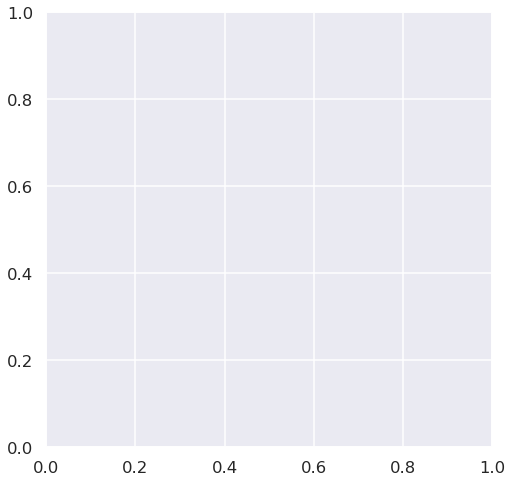

In [19]:
fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(cmass_train, no_train, label='training data')
#ax.scatter(X[Y==1, 0], X[Y==1, 1], color='r', label='Class 1')
sns.despine(); ax.legend()
#ax.set(xlabel='X', ylabel='Y', title='Toy binary classification data set');

In [ ]:
def construct_nn(ann_input, ann_output):
    n_hidden = 5

    # Initialize random weights between each layer
    init_1 = np.random.randn(X.shape[1], n_hidden).astype(floatX)
    init_2 = np.random.randn(n_hidden, n_hidden).astype(floatX)
    init_out = np.random.randn(n_hidden).astype(floatX)

    with pm.Model() as neural_network:
        # Trick: Turn inputs and outputs into shared variables using the data container pm.Data
        # It's still the same thing, but we can later change the values of the shared variable
        # (to switch in the test-data later) and pymc3 will just use the new data.
        # Kind-of like a pointer we can redirect.
        # For more info, see: http://deeplearning.net/software/theano/library/compile/shared.html
        ann_input = pm.Data('ann_input', cmass_train)
        ann_output = pm.Data('ann_output', no_train)

        # Weights from input to hidden layer
        weights_in_1 = pm.Normal('w_in_1', 0, sigma=1,
                                 shape=(X.shape[1], n_hidden),
                                 testval=init_1)

        # Weights from 1st to 2nd layer
        weights_1_2 = pm.Normal('w_1_2', 0, sigma=1,
                                shape=(n_hidden, n_hidden),
                                testval=init_2)

        # Weights from hidden layer to output
        weights_2_out = pm.Normal('w_2_out', 0, sigma=1,
                                  shape=(n_hidden,),
                                  testval=init_out)

        # Build neural-network using tanh activation function
        act_1 = pm.math.tanh(pm.math.dot(ann_input,
                                         weights_in_1))
        act_2 = pm.math.tanh(pm.math.dot(act_1,
                                         weights_1_2))
        act_out = pm.math.sigmoid(pm.math.dot(act_2,
                                              weights_2_out))

        # Binary classification -> Bernoulli likelihood
        out = pm.Bernoulli('out',
                           act_out,
                           observed=ann_output,
                           total_size=no_train.shape[0] # IMPORTANT for minibatches
                          )
    return neural_network

neural_network = construct_nn(cmass_train, no_train)

## Still a work in progress --- need to work out bugs to have it run completely.